# **Flight Fare Predictor🛫**
**Author:** Amy Lee

**Project Focus:** Data Science + Machine Learning

---

### 📋 **Project Overview**

This project predicts average fares for U.S. domestic flights using machine learning. The goal is to understand pricing patterns and build a generalizable model that helps users estimate flight costs, optionally displaying feature insights and visualizations. The model is deployed in an interactive app using Streamlit (see `Flight_predictor.py`).

**Key Features**
- Interactive Streamlit web application
- Multiple model comparison
- Feature importance analysis
- Model performance visualization

**Objectives**
- Understand key features that influence domestic flight ticket prices
- Train and evaluate predictive models
- Interpret model performance and feature importance
- Visualize results through graphs and plots
- Build an interactive app for fare estimation

### **Dataset Description**

- File: 'domestic.csv'
- Source: https://www.kaggle.com/datasets/amitzala/us-airline-flight-routes-and-fares
- Records: ~100K domestic flight routes from 1993 to 2024
- Target Variable: `fare` (average ticket price)

**Key Features**
| Feature | Description | Type |
| ------- | ----------- | ---- |
| `nsmiles` | Distance between airports (miles) | Numeric |
| `passengers` | Number of passengers on route | Numeric |
| `quarter` | Flight quarter (1-4) | Categorical |
| `large_ms` | Market share of the largest carrier (0-1) | Numeric |
| `lf_ms` | Market share of the lowest fare carrier (0-1) | Numeric |
| `fare_low` | Lowest fare offered ($) | Numeric |
| `fare_lg` | Average fare of largest carrier ($) | Numeric |
| `city1`, `city2` | Origin and destination cities | Categorical |


### **Modeling Approach & Setup**

We offer two models for fare prediction:
- **Full Model:** Uses all relevant features (including carrier data and fare prices) to maximize prediction accuracy
- **Minimal Model:** Uses only `nsmiles` and `quarter` to provide a simplified prediction in cases where detailed pricing data is unavailable

The models use **Random Forest Regressor** because it handles nonlinear relationships effectively, is robust to outliers, and outperforms simpler models like linear regression on complex datasets like airline fares. Further, it makes predictions quickly once trained, which is ideal for the Streamlit application.

In [3]:
# First, import necessary libraries
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import gdown
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import os
%matplotlib inline

# Load dataset
def load_data():
    try:
        df = pd.read_csv("domestic.csv")
        return df
    except FileNotFoundError:
        print("domestic.csv file not found. Please ensure the file is in the same directory.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    
# Load the main dataset
df_main = load_data()
if df_main is None:
    raise Exception("Could not load dataset. Please check the file path.")

print(f"Dataset loaded successfully: {df_main.shape[0]} rows, {df_main.shape[1]} columns")

Dataset loaded successfully: 114035 rows, 18 columns


###  **Model Loading**
The full model was pre-trained using the logic in `train_model.py` and saved for reuse, while the minimal model is lightweight and trained on demand below. Here, we load both models for analysis.

In [5]:
# Full model
def load_model():
    file_id = "1yK9Xn30O_EotvDpHDgBSnO-cSaI4Hdyq"
    download_url = f"https://drive.google.com/uc?id={file_id}"
    output = "model.pkl"

    # Only download if file doesn't exist
    if not os.path.exists(output):
        try:
            gdown.download(download_url, output, quiet=False)
        except Exception as e:
            print(f"Failed to download model: {e}")
            return None
    
    try:
        with open(output, "rb") as f:
            model = pickle.load(f)
        return model
    except Exception as e:
        print(f"Failed to load model: {e}")
        return None
    
# Minimal model
def load_minimal_model():
    df = load_data()
    if df is None:
        return None
    
    df_clean = df.dropna(subset=['nsmiles', 'quarter', 'fare'])
    if df_clean.empty:
        print("No valid data found for minimal model training")
        return None
    
    X_min = df_clean[['nsmiles', 'quarter']]
    y_min = df_clean['fare']
    minimal_model = RandomForestRegressor(random_state=42, n_estimators=50)
    minimal_model.fit(X_min, y_min)
    return minimal_model

# Load both models
model = load_model()
minimal_model = load_minimal_model()

if model is None or minimal_model is None:
    raise Exception("Could not load required models")

### **UI Setup**
Following the initialization and imports, we create a simple UI that allows users to select between the full model and minimal model, and choose the specific features to predict their fare. 

Users can select:
- Full Model or Minimal Model
- Origin and destination city
- Distance if not already calculated
- Quarter of the year
- Number of passengers, market share of largest carrier, market share of lowest fare carrier, lowest fare offered, and average fare of largest carrier if full model

To make the UI more practical for the user, these functions get the distance between the chosen cities if the `nsmiles` is included in the dataset already. Otherwise, the user can manually enter the distance.

Finally, they can checkmark `Show Feature Importance`, `Show Predicted vs. Actual`, and `Show Data Info` to give more insight into the model and dataset.


### **Example Prediction**
Here, we demonstrate full and minimal model predictions with a practical example: Los Angeles to New York.

In [6]:
# Common inputs
nsmiles = 2510 # LA to NYC distance
quarter = 2 # Q2

# Full model inputs
passengers = 200
large_ms = 0.5 # 50% market share for largest carrier
lf_ms = 0.2 # 20% market share for lowest fare carrier
fare_low = 100 # Lowest fare
fare_lg = 150 # Average fare of largest carrier

# Full model prediction
input_full = pd.DataFrame([[nsmiles, passengers, quarter, large_ms, lf_ms, fare_low, fare_lg]],
                          columns=['nsmiles', 'passengers', 'quarter', 'large_ms', 'lf_ms', 'fare_low', 'fare_lg'])
fare_full = model.predict(input_full)[0]

# Minimal model prediction
input_min = pd.DataFrame([[2450, 2]], columns=['nsmiles', 'quarter'])
fare_min = minimal_model.predict(input_min)[0]

# Print results
print(f"Full Model Fare: ${fare_full:.2f}")
print(f"Minimal Model Fare: ${fare_min:.2f}")

Full Model Fare: $152.37
Minimal Model Fare: $311.16


### **Feature Importance**
Understanding which features drive fare predictions for each model helps explain model behavior and provides business insights.

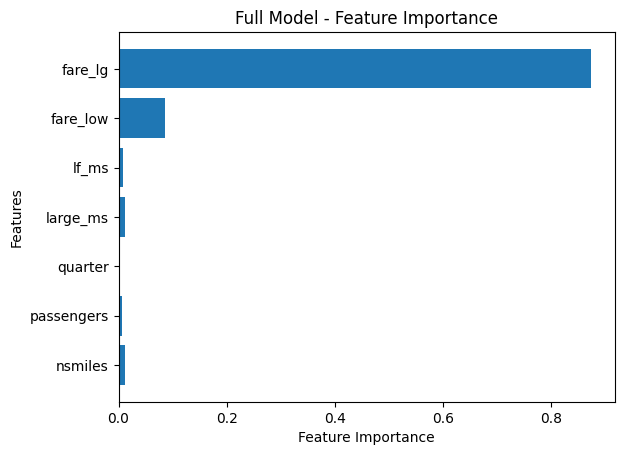

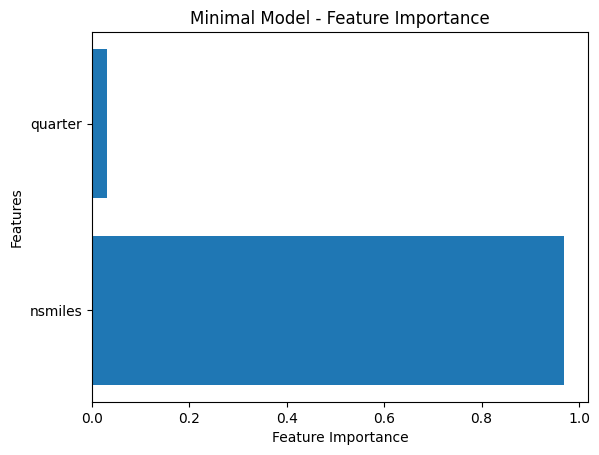

In [20]:
# Full Model
importances_full = model.feature_importances_
features_full = ['nsmiles', 'passengers', 'quarter', 'large_ms', 'lf_ms', 'fare_low', 'fare_lg']

plt.barh(features_full, importances_full)
plt.title("Full Model - Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

# Minimal model
importances_min = minimal_model.feature_importances_
features_min = ['nsmiles', 'quarter']

plt.barh(features_min, importances_min)
plt.title("Minimal Model - Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

### **Model Evaluation**

We can compare the predicted fares vs. actual fares to understand their predictive performance.

In [ ]:
# Full model evaluation
df_clean_full = df_main.dropna(subset=['nsmiles', 'passengers', 'quarter', 'large_ms', 'lf_ms', 'fare_low', 'fare_lg', 'fare'])
X_full = df_clean_full[['nsmiles', 'passengers', 'quarter', 'large_ms', 'lf_ms', 'fare_low', 'fare_lg']]
y_full = df_clean_full['fare']
y_pred_full = model.predict(X_full)

# Minimal model evaluation
df_clean_min = df_main.dropna(subset=['nsmiles', 'quarter', 'fare'])
X_min = df_clean_min[['nsmiles', 'quarter']]
y_min = df_clean_min['fare']
y_pred_min = minimal_model.predict(X_min)

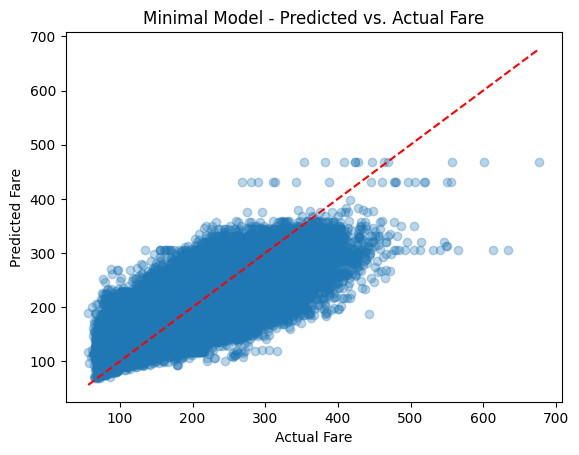

In [9]:
# Plot predicted vs. actual - Minimal model
plt.scatter(y_min, y_pred_min, alpha=0.3)
plt.plot([y_min.min(), y_min.max()], [y_min.min(), y_min.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Minimal Model - Predicted vs. Actual Fare")
plt.show()

### **Metrics Summary**
We can evaluate the strength of each model through their mean squared errors, r2 scores, and root mean squared errors.

In [11]:
mse_full = mean_squared_error(y_full, y_pred_full)
r2_full = r2_score(y_full, y_pred_full)
rmse_full = np.sqrt(mse_full)

mse_min = mean_squared_error(y_min, y_pred_min)
r2_min = r2_score(y_min, y_pred_min)
rmse_min = np.sqrt(mse_min)

print(f"Full Model - R²: {r2_full:.3f}, RMSE: {rmse_full:.2f}, MSE: {mse_full:.2f}")
print(f"Minimal Model - R²: {r2_min:.3f}, RMSE: {rmse_min:.2f}, MSE: {mse_min:.2f}")

Full Model - R²: 0.991, RMSE: 5.90, MSE: 34.82
Minimal Model - R²: 0.564, RMSE: 41.17, MSE: 1694.88


## 📊 **Conclusion**

The full model demonstrates strong predictive power, with a nearly perfect R² score and low RMSE and MSE, suggesting high accuracy. In contrast, the minimal model is understandably less accurate due to its reliance on only 2 features--primarily `nsmiles` (distance). The R² still indicates a moderate fit. Though the MSE and RMSE are higher than those of the full model, they remain reasonable given that typical fares range from 150 to 400+ USD.

The difference in performance highlights that flight prices vary greatly due to *carrier pricing, demand, and fare competition.* The `fare_lg` and `fare_low` variables being the strongest features for prediction indicate how significant market competition is for fare pricing, regardless of simply distance. Despite the reduced accuracy of the minimal model, it remains valuable for user-facing predictions where full pricing and market share data is not available.

**🚀 Future Steps**
- **Expand dataset:** Train on a larger and more recent dataset, possibly with international routes for broader coverage
- **Integrate real-time APIs:** Connect to flight pricing APIs to support the most accurate, live fare estimates
- **Model enhancements:** Fine-tune hyperparameters, enhance testing with data augmentation to make model more robust
- **User personalization:** Include additional features like day-of-the-week, month or holiday season, or airline preference to reflect real-life booking scenarios